# Load Data

In [1]:
%matplotlib notebook
import os
import mne
import numpy as np
import matplotlib.pyplot as plt

from idtxl.multivariate_te import MultivariateTE
from idtxl.data import Data
from idtxl.visualise_graph import plot_network
from idtxl.active_information_storage import ActiveInformationStorage

In [2]:
dataS = mne.io.read_raw_edf('./data/s01.edf')
dataH = mne.io.read_raw_edf('./data/h01.edf')

Extracting EDF parameters from /home/camilojd/Universidad/Primavera_2020/EL7006/proyecto/data/s01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/camilojd/Universidad/Primavera_2020/EL7006/proyecto/data/h01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [3]:
print(dataS.info)

<Info | 7 non-empty values
 bads: []
 ch_names: Fp2, F8, T4, T6, O2, Fp1, F7, T3, T5, O1, F4, C4, P4, F3, C3, ...
 chs: 19 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2004-08-20 12:19:24 UTC
 nchan: 19
 projs: []
 sfreq: 250.0 Hz
>


In [4]:
print('Idx | Name Channel')
print('----|-------------')
for i,j in enumerate(dataS.ch_names):
    print('%3d | %s'%(i,j))

Idx | Name Channel
----|-------------
  0 | Fp2
  1 | F8
  2 | T4
  3 | T6
  4 | O2
  5 | Fp1
  6 | F7
  7 | T3
  8 | T5
  9 | O1
 10 | F4
 11 | C4
 12 | P4
 13 | F3
 14 | C3
 15 | P3
 16 | Fz
 17 | Cz
 18 | Pz


# Visualization

Schizophrenic EEG (Raw)


<IPython.core.display.Javascript object>


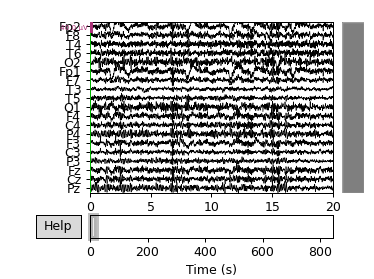

<IPython.core.display.Javascript object>


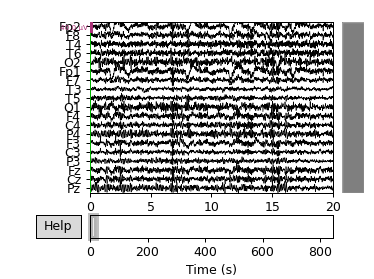

In [5]:
print('Schizophrenic EEG (Raw)')
dataS.plot(duration=20,title="Schizophrenic EEG (Raw)")

Healthy EEG (Raw)


<IPython.core.display.Javascript object>


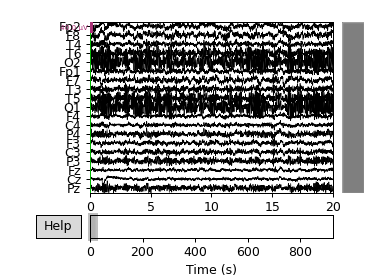

<IPython.core.display.Javascript object>


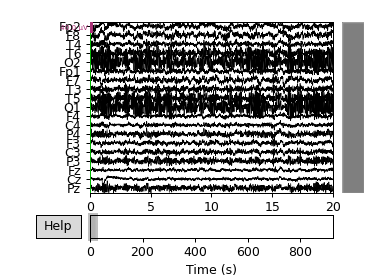

In [6]:
print('Healthy EEG (Raw)')
dataH.plot(duration=20,title="Healthy EEG (Raw)")

Schizophrenic EEG (Alpha band)
Setting up band-pass filter from 8 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 8.00, 12.50 Hz: -6.02, -6.02 dB



<IPython.core.display.Javascript object>


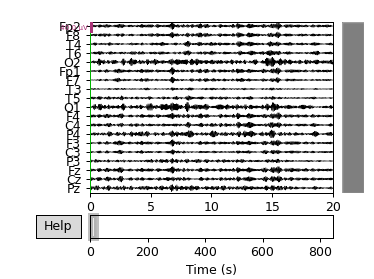

<IPython.core.display.Javascript object>


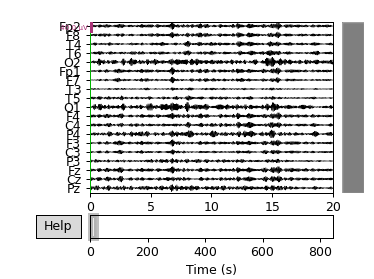

In [7]:
print('Schizophrenic EEG (Alpha band)')
dataS.plot(duration=20, lowpass=12.5, highpass=8, filtorder=2, title="Schizophrenic EEG (Alpha band)")

Health EEG (Alpha band)
Setting up band-pass filter from 8 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 8.00, 12.50 Hz: -6.02, -6.02 dB



<IPython.core.display.Javascript object>


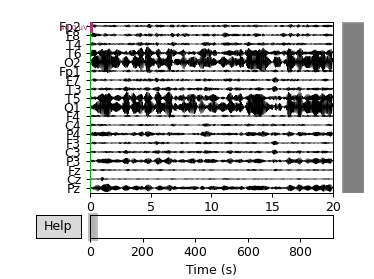

<IPython.core.display.Javascript object>


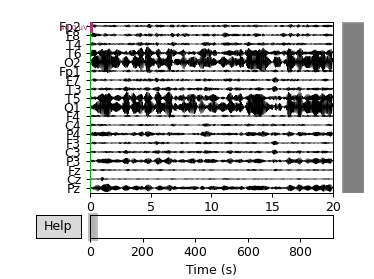

In [8]:
print('Health EEG (Alpha band)')
dataH.plot(duration=20, lowpass=12.5, highpass=8, filtorder=2, title="Healthy EEG (Alpha band)")

# Filter data

In [9]:
def filter_eeg(dataXX, type_filter='alpha'):
    if type_filter.lower() == 'alpha':
        l_freq = 12.5
        h_freq = 8
    elif type_filter.lower() == 'beta':
        l_freq = 13
        h_freq = 30
    elif type_filter.lower() == 'gamma':
        l_freq = 45
        h_freq = 30
    elif type_filter.lower() == 'delta':
        l_freq = 4
        h_freq = 2
    elif type_filter.lower() == 'theta':
        l_freq = 7.5
        h_freq = 4.5
    return mne.filter.filter_data(dataXX.get_data(), dataXX.info['sfreq'],
                                  l_freq=l_freq, 
                                  h_freq=h_freq,
                                  method='iir',
                                  iir_params=dict(order=2, ftype='butter')
                                 )

Setting up band-stop filter from 8 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 8.00, 12.50 Hz: -6.02, -6.02 dB



<IPython.core.display.Javascript object>


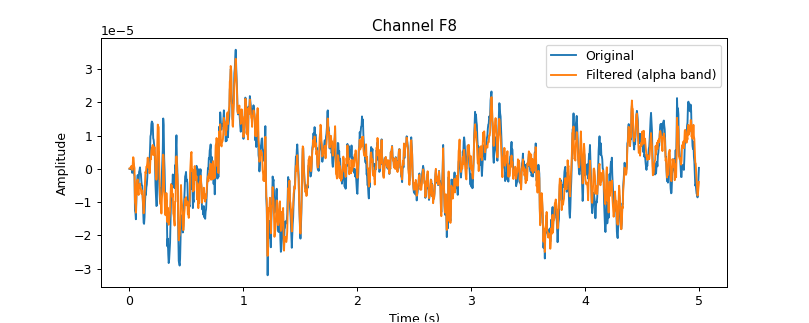

Text(0.5, 1.0, 'Channel F8')

In [10]:
datax = dataH
t = 5 #seconds
filter_type = 'alpha'
nch = 1

n = int(datax.info['sfreq']*t)
tt = np.linspace(0,t,n)
A = filter_eeg(datax, filter_type)
plt.figure(figsize=(10,4))
plt.plot(tt, datax.get_data()[nch,:n],label='Original')
plt.plot(tt, A[nch,:n],label='Filtered (%s band)'%(filter_type))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Channel %s'%(datax.ch_names[nch]))

# Active Information Storage (AIS)

In [11]:
dataAIS = Data(data=A[nch,:n].reshape(1,-1), dim_order='ps') 
network_analysis = ActiveInformationStorage()
settings = {'cmi_estimator':  'JidtKraskovCMI',
           'max_lag': 5,
           'local_values':True,
           'n_perm_max_stat': 11,
           'n_perm_min_stat': 11,
           'alpha_max_stat': 0.1,
           'n_perm_omnibus': 11,
           'alpha_omnibus': 0.1,
           'n_perm_max_seq': 11,
           'alpha_max_seq': 0.1, 
           'alpha_min_stat': 0.1}

# c) Run analysis
results = network_analysis.analyse_network(settings=settings, data=dataAIS)

Adding data with properties: 1 processes, 1250 samples, 1 replications
overwriting existing data

####### analysing process 0 of [0]

---------------------------- (1) include candidates
testing candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate (0, 1) 
maximum statistic, n_perm: 11
testing candidate (0, 5) maximum statistic, n_perm: 11
 -- not significant

---------------------------- (2) prune source candidates
testing candidate set: [(0, 1)]testing candidate: (0, 1)
minimum statistic, n_perm: 11
 -- significant

---------------------------- (3) final statistics
selected sources: [(0, 1)]
mi permutation test against surrogates, n_perm: 500
final conditional samples: [(0, 1)]


<IPython.core.display.Javascript object>


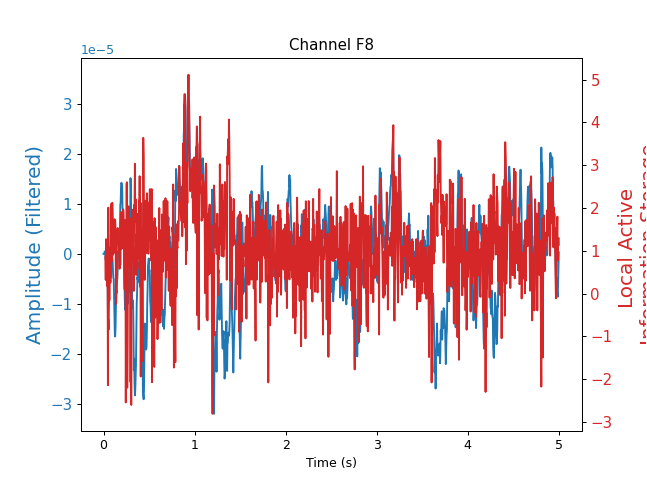

Text(0.5, 1.0, 'Channel F8')

In [12]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
color = 'tab:blue'
ax12 = ax.twinx()
ax.plot(tt, datax.get_data()[nch,:n], label='Original',color=color)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (Filtered)', color=color, fontsize=16)
ax.tick_params(axis='y', labelcolor=color, labelsize=12)
color = 'tab:red'
ax12.plot(tt[results.settings['max_lag']:],results.get_single_process(0)['ais'][0], color=color)
ax12.set_ylabel('Local Active \nInformation Storage', color=color, fontsize=16)
ax12.tick_params(axis='y', labelcolor=color, labelsize=12)
ax.set_title('Channel %s'%(datax.ch_names[nch]))